<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Recomendando Música

El objetivo de este caso-taller es construir un sistema de recomendación de Música utilizando los datos de [Last.fm](https://www.last.fm/) provistos  abiertamente por [grouplens](https://grouplens.org/about/what-is-grouplens/) para: **"avanzar la teoría y la práctica de la computación social mediante la construcción y la comprensión de sistemas *(de recomendación)* utilizados por personas reales".**

Los datos contienen información sobre artistas, usuarios, y las veces que estos escucharon sus canciones. Las bases se encuentran en los `Archivos de Laboratorio` en la carpeta `data`, allí también está disponible un archivo [README](data/readme.txt) que contiene más información sobre las bases.


## Instrucciones generales

1. Para desarrollar el *cuaderno*, primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos 

En la carpeta `data` se encuentran los archivos:

   - `artists.dat`  que contienen el identificador del artista (`id`), nombre (`name`), link a la página del artista en last.fm (`url`), y link a la imagen del usuario (`pictureURL`), vale aclarar que varios de estos links están rotos. 
   - `user_artists.dat`  que contiene identificador del usuario (`userID`), nombre del artista que escuchó (`artistID`), y las veces que los escuchó (`weight`).

Cargue estos datos en su *cuaderno*:

   1. Para la base de artistas seleccione las columnas de identificador de artista (`id`) y nombre (`name`). Renombre estas columnas para poder hacer la unión con la base `user_artists.dat`.
   2. Para la base de usuarios y artistas, renombre las columnas de forma tal que se mantenga la consistencia para unir con la base anterior, y renombre la columna `weight` a `nro_reproducciones`.
   3. Una estas bases.
   

In [45]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import apyori as ap
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy.linalg import svd

In [2]:
# Cargar datos de artistas
df_artists = pd.read_csv('./data/artists.dat', sep='\t')
df_artists.rename(columns={'id': 'artistID'}, inplace=True)
df_artists.drop(columns=['url', 'pictureURL'], inplace=True)

# Cargar datos de usuarios
df_users = pd.read_csv('./data/user_artists.dat', sep='\t')
df_users.rename(columns={'weight': 'nro_reproducciones'}, inplace=True)

# Unir la bases
df = pd.merge(df_users, df_artists, on='artistID')
df.head()

,userID,artistID,nro_reproducciones,name
0,2,51,13883,Duran Duran
1,4,51,228,Duran Duran
2,27,51,85,Duran Duran
3,28,51,10,Duran Duran
4,62,51,528,Duran Duran


El primer paso es improtar las librerías que se van a necesitar en este notebook. Seguido a esto se procede a leer los archivos de artistas y usuarios renombrando la columna 'id' de la base de artistas a 'artistsID' y removiendo las columnas de las urls que no se van a necesitar. Finalmente, se unen los dos dataframes en la columna de 'artistsID'.

### 2. Análisis preliminar. 

En esta sección exploraremos la base. Para ello responda las siguientes preguntas.

#### 2.1 ¿Cuantos usuarios y artistas hay en la base?



#### 2.2 ¿Cuáles es la distribución de probabilidad del consumo por artista? (haga el calculo sin ponderar y ponderando por el numero de reproducciones) ¿Qué podemos inferir a partir de la comparación de ambas?

In [3]:
# Calcular cuántos usuarios y artistas hay
total_users = df.userID.nunique()
total_artists = df.artistID.nunique()

print(f'Hay {total_users} usuarios y {total_artists} artistas')

# Calcular la distribución de probabilidad de consumo por artista
df_artist_consumption = df.groupby('artistID').agg({'userID': 'count'})
df_artist_w_consumption = df.groupby('artistID').agg({'nro_reproducciones': 'sum'})

Hay 1892 usuarios y 17632 artistas


/var/folders/xq/zz5zb6z90_73_lf9wzs007h40000gn/T/ipykernel_3958/3362562551.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_artist_consumption['prob'], ax=ax[0])
/var/folders/xq/zz5zb6z90_73_lf9wzs007h40000gn/T/ipykernel_3958/3362562551.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

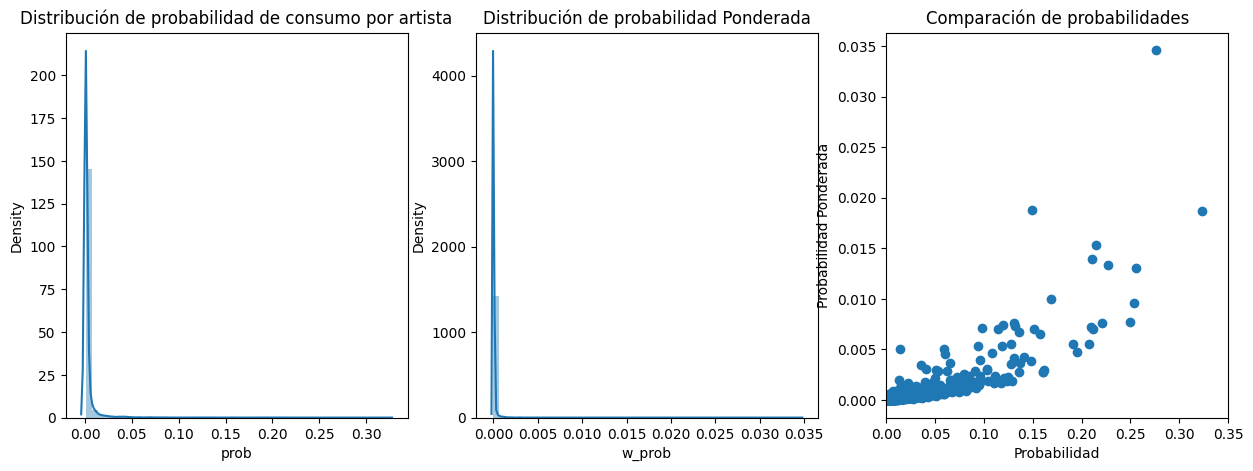

In [4]:
# Agregar la columna de nombre de artista
df_artist_consumption = pd.merge(df_artist_consumption, df_artists, on='artistID')
df_artist_consumption.rename(columns={'userID': 'users_consumption'}, inplace=True)
df_artist_w_consumption = pd.merge(df_artist_w_consumption, df_artists, on='artistID')

# Calcular la probabilidad de consumo
df_artist_consumption['prob'] = df_artist_consumption['users_consumption'] / total_users
df_artist_w_consumption['w_prob'] = df_artist_w_consumption['nro_reproducciones'] / df_artist_w_consumption['nro_reproducciones'].sum()

# Unir probabilidades
df_probs = pd.merge(df_artist_consumption, df_artist_w_consumption[['artistID','w_prob']], on='artistID', how='inner')

# Graficar la distribución de probabilidad de consumo
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.distplot(df_artist_consumption['prob'], ax=ax[0])
ax[0].set_title('Distribución de probabilidad de consumo por artista')
sns.distplot(df_artist_w_consumption['w_prob'], ax=ax[1])
ax[1].set_title('Distribución de probabilidad Ponderada')
ax[2].set_title('Comparación de probabilidades')
ax[2].scatter(df_probs['prob'], df_probs['w_prob'])
plt.xlabel('Probabilidad')
plt.ylabel('Probabilidad Ponderada')
plt.xlim(0, 0.35)
plt.show()

Graficando las probabilidades simples, se puede observar que el "número de casos exitosos" para cada artista es más homogéneo entre artistas y por ende el eje y muestra que hay una menor frecuencia para cada artista en comparación con el eje y de la gráfica de las probabilidades ponderadas. Para esta segunda gráfica se puede ver cómo el 'share market' de cada artista se ve reflejado pues para los artistas más famosos no cuenta simplemente el hecho de que la mayoría de gente los escucha sino también cuántas veces son escuchados por toda esta población, haciendo que para artistas menos reconocidos exista una menor probabilidad de consumo pues en este caso el "número de casos exitosos" debe considerar todas las reproducciones totales y no solo si existe una persona que escucha al artista. Finalmente, en la tercera gráfica se comparan ambas probabilidades ratificando las conclusiones expuestas pues, de no haber diferencia entre estas, se debería graficar una línea recta, pero como se puede ver, hay casos en el que la probabilidad ponderada es mucho mayor y esto se debe a que tienen un share grande del mercado, es decir, son escuchados con mucha más frecuencia que el resto de artistas.

#### 2.3 Para el usuario 8 (`userID==8`) ¿cuál es la distribución de reproducción de artistas basado en el número de reproducciones relativas?. Presente sus resultados usando tablas y/o gráficas. ¿Encuentra algún patrón en los artistas que escucha y las veces que reproduce? ¿Podemos decir algo de sus preferencias?


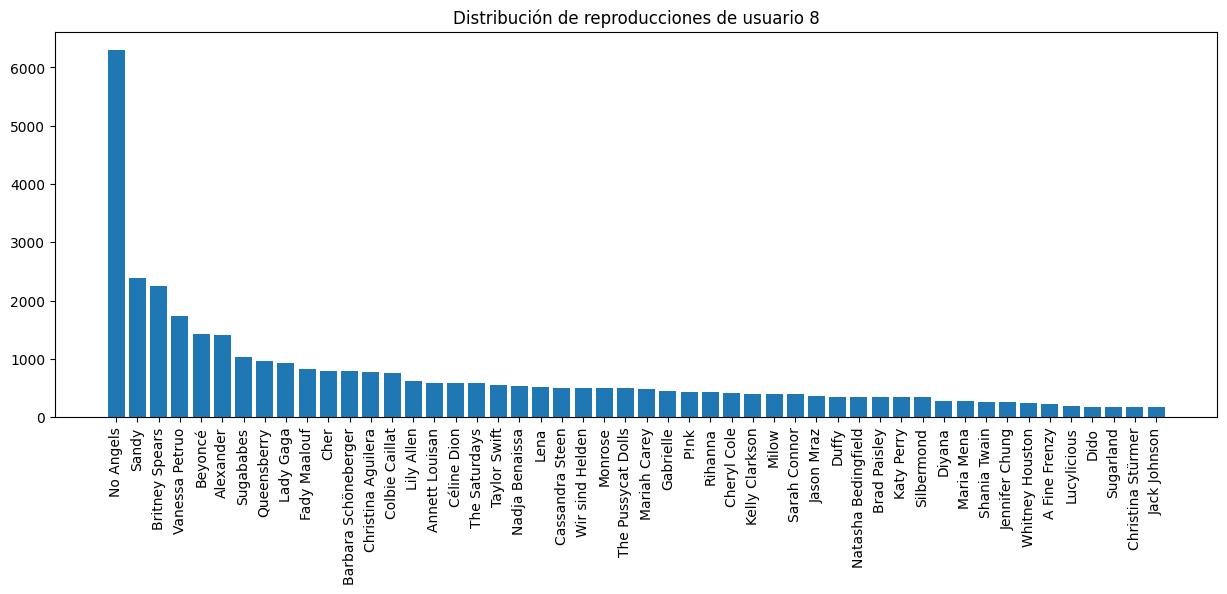

In [7]:
# Distribución de reproducciones de usuario 8
df_user8 = df[df['userID'] == 8]

# Ordenar por reproducciones
df_user8.sort_values(by='nro_reproducciones', ascending=False, inplace=True)

# Graficar distribución de reproducciones de usuario 8
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(df_user8['name'], df_user8['nro_reproducciones'])
plt.title('Distribución de reproducciones de usuario 8')
plt.xticks(rotation=90)
plt.show()

Para este análisis se filtró dentro del dataframe las reproducciones del usuario 8, se ordenó el número de reproducciones de mayor a menor y se graficó la frecuencia de reproducciones de cada uno de los artistas que escucha este usuario. Dentro de los artistas que se encuentran en la gráfica, se puede ver que en su mayoría son artistas pop y mujeres.

### 3. Generando Recomendaciones

En esta sección nos interesa generar recomendaciones ***nuevas y relevantes*** para el usuario 8 (`userID==8`). Para ello vamos a generar distintos sistemas de recomendación y comparar las recomendaciones generadas.

#### 3.1. Filtrado colaborativo sencillo: promedios simples.

Usando el promedio simple de reproducciones (sin considerar el número de reproducciones) genere una tabla y/o gráfica con 10 recomendaciones de artistas para este usuario. Explique con cuidado su procedimiento y justifique sus elecciones.

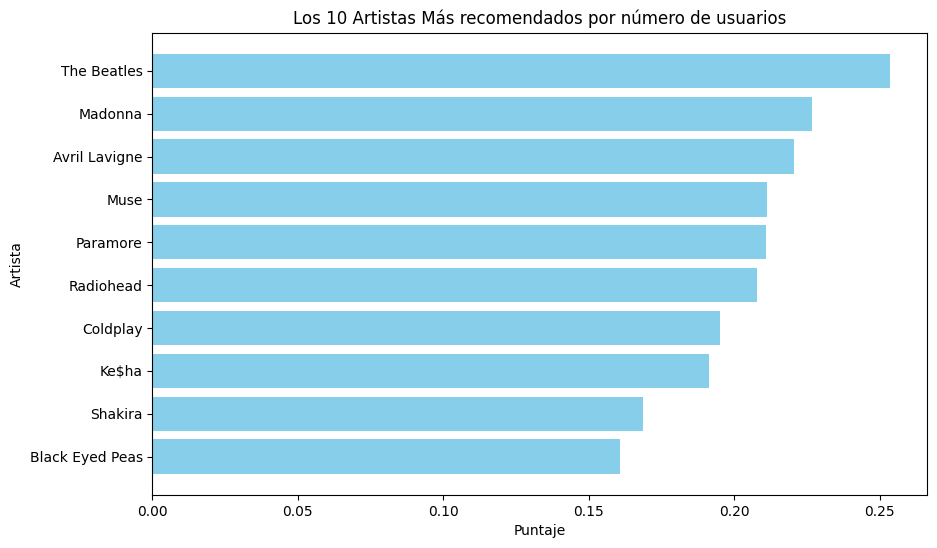

In [32]:
# Se crea la matriz de frecuencias. Si el usuario ha escuchado al artista, se coloca 1, de lo contrario 0
r_matrix = df.pivot_table(values='nro_reproducciones', index='userID', columns='artistID')
r_matrix_dummy = r_matrix.notna().astype(int)
r_matrix_dummy

# Función para calcular la similitud entre usuarios
def cf_user_mean(r_matrix, artistID):
    if artistID in r_matrix:
        mean_rating = r_matrix[artistID].mean()
    else:
        mean_rating = 0
    return mean_rating

# Calcular la similitud entre usuarios
artistID_list = df['artistID'].unique()  
scores = []

for artistID in artistID_list:
    mean_rating = cf_user_mean(r_matrix_dummy, artistID)
    scores.append({"artistID": artistID, "score": mean_rating})

# Función para graficar el rating
def plot_artist_ranking(scores, df_artists, title):
    # Convertir diccionario a dataframe
    scores_df = pd.DataFrame(scores)
    # Agregar las columnas de id de artista y nombre de artista
    scores_df = scores_df.merge(df_artists[['artistID', 'name']], on='artistID', how='left')
    # Agregar el nombre de los artistas que escucha el usuario 8
    scores_df = scores_df.merge(df_user8[['name']], on='name', how='left', indicator=True)
    # Filtrar los artistas que no escucha el usuario 8 para hacerle las recomendaciones
    scores_df = scores_df[scores_df['_merge'] == 'left_only']

    artistas_populares = scores_df.sort_values(by='score', ascending=False).head(10)

    # Crear un gráfico de barras horizontal
    plt.figure(figsize=(10, 6))  # Ajustar el tamaño del gráfico
    plt.barh(artistas_populares['name'], artistas_populares['score'], color='skyblue')
    plt.xlabel('Puntaje')
    plt.ylabel('Artista')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invertir el eje y para mostrar el artista más popular en la parte superior

    # Mostrar el gráfico
    plt.show()

# Graficar el rating
plot_artist_ranking(scores, df_artists, 'Los 10 Artistas Más recomendados por número de usuarios')

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 3.2.  Filtrado colaborativo sencillo: promedios ponderados.

Usando el promedio de reproducciones ponderado por `nro_reproducciones` genere una tabla y/o gráfica con 10 recomendaciones de artistas para este usuario. Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en el paso anterior.


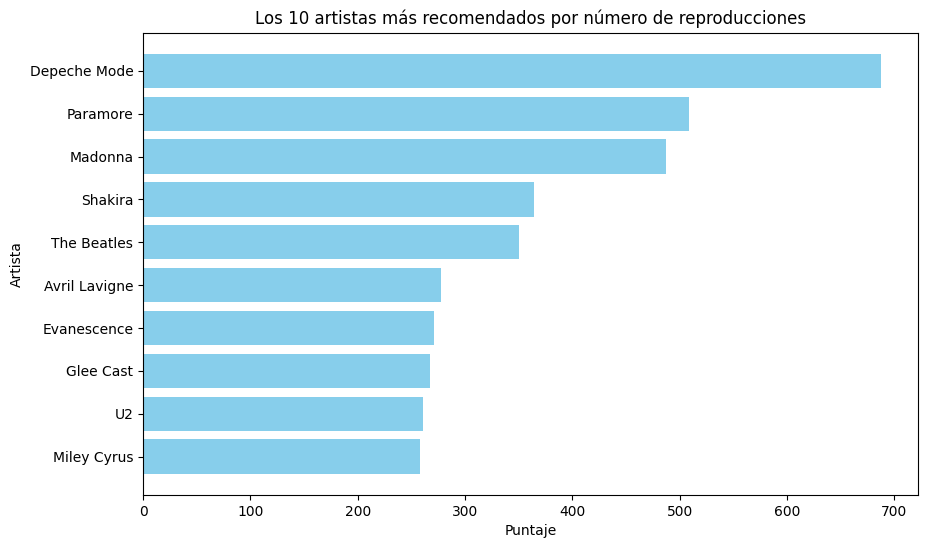

In [33]:
# Tabla con usuarios y número de reproducciones por artista
r_matrix = df.pivot_table(values='nro_reproducciones', index='userID', columns='artistID').fillna(0)

# Reiniciar la lista de scores
scores.clear()

for artistID in artistID_list:
    mean_rating = cf_user_mean(r_matrix, artistID)
    scores.append({"artistID": artistID, "score": mean_rating})

# Graficar el rating
plot_artist_ranking(scores, df_artists, 'Los 10 artistas más recomendados por número de reproducciones')

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 3.3.  Filtrado colaborativo sencillo: similitud de coseno.

Usando el promedio ponderado de reproducciones genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario. Para generar los pesos utilice la distancia de coseno. Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en el paso anterior.

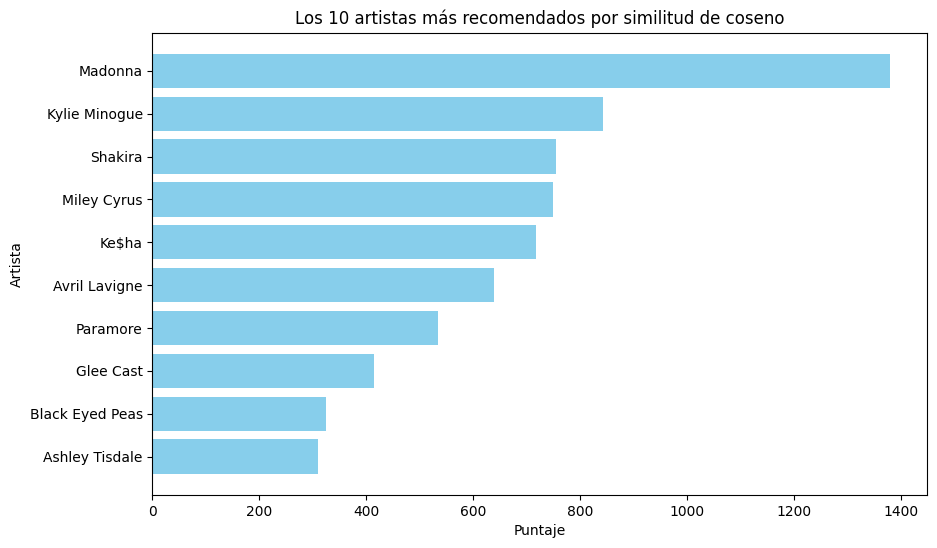

In [34]:
#Calculamos la similitud de coseno 
cosine_sim = cosine_similarity(r_matrix, r_matrix)

# Transformamos la matriz resultante en un dataframe
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.index, columns=r_matrix.index)

cosine_sim.head(10)

def cf_user_wmean(user_id, artistID):
    # Primero verificamos si la película esta en la matriz
    if artistID in r_matrix:
        #Buscamos las medidas de similitud con los otros usuarios
        sim_scores = cosine_sim[user_id]
        # Obtenemos los ratings no faltantes de la matriz bajo evaluación
        m_ratings = r_matrix[artistID]
        # Obtenemos los índicies de las películas sin rating 
        idx = m_ratings[m_ratings.isnull()].index
        # Nos quedamos con similitudes y ratings completos
        sim_scores = sim_scores.drop(idx)
        m_ratings = m_ratings.dropna()
        # Calculamos la media ponderada
        wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()
    else:
        # Si no tenemos ninguna información retornamos 0
        wmean_rating = 0
    
    return wmean_rating

# Calcular la similitud entre usuarios
scores = []

for artistID in artistID_list:
    mean_rating = cf_user_wmean(8, artistID)
    scores.append({"artistID": artistID, "score": mean_rating})

# Graficar el rating
plot_artist_ranking(scores, df_artists, 'Los 10 artistas más recomendados por similitud de coseno')

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 3.4.  Filtrado colaborativo usando SVD


Usando la descomposición en valores singulares (SVD) genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario.  Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en los pasos anteriores.


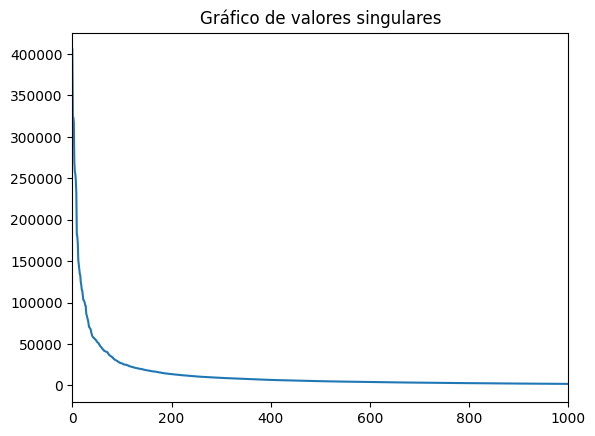

La varianza explicada por los primeros 100 valores singulares es 0.951291


In [72]:
# Pasar a matriz dispersa para poder aplicar SVD
A = r_matrix.to_numpy()
# Calcular la media de las calificaciones de cada usuario
user_ratings_mean = np.mean(A, axis = 1)
# Restar la media de las calificaciones de cada usuario para normalizar
A_demeaned = A - user_ratings_mean.reshape(-1, 1)
# Calcular SVD
U, sigma, Vt = svd(A_demeaned)
# Graficar los valores singulares
x_coordinate = [i for i in range(len(sigma)) ]
plt.plot(x_coordinate,sigma)
plt.title('Gráfico de valores singulares')
plt.xlim(0, 1000)
plt.show()
# Calcular la varianza explicada
var_explained = np.round(sigma**2/np.sum(sigma**2), decimals=6)
vs = 100
print(f'La varianza explicada por los primeros {vs} valores singulares es {sum(var_explained[0:vs])}')

In [73]:
# Calcular la matriz de recomendaciones
U, sigma, Vt = svds(A_demeaned, k = vs)
sigma = np.diag(sigma)
A_recomendaciones = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
recomendac_df = pd.DataFrame(A_recomendaciones, columns = r_matrix.columns)
recomendac_df.head(10)

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
0,2.033813,5.224558,0.650398,1.489550,1.962391,-15.348861,90.160239,18.164756,2.470251,0.960792,...,2.501171,1.989224,1.745287,1.698746,1.604060,1.573568,1.562334,1.551100,1.549495,-0.998452
1,1.194764,1.188069,1.184917,1.185820,1.201188,1.033677,-1.160870,0.727358,1.096808,1.259612,...,1.189457,1.188005,1.187314,1.187182,1.186914,1.186827,1.186795,1.186763,1.186759,1.164497
2,0.689183,0.764240,0.353082,0.425605,0.532978,1.513865,-16.581012,-0.043575,1.348333,2.274401,...,0.402998,0.380830,0.370267,0.368251,0.364151,0.362831,0.362345,0.361858,0.361789,0.181378
3,0.020067,0.296278,-0.058060,0.099957,0.186824,-0.123308,5.046489,-0.513088,2.494495,3.426673,...,-0.038857,-0.044141,-0.046659,-0.047139,-0.048116,-0.048431,-0.048547,-0.048663,-0.048679,0.214308
4,0.048156,0.040642,0.049110,0.048797,0.048883,0.049199,0.600705,0.055137,0.043836,0.051172,...,0.048901,0.049010,0.049063,0.049073,0.049093,0.049099,0.049102,0.049104,0.049105,0.049492
5,-0.876509,-2.670086,-0.715243,-0.565705,-0.823352,-2.525956,-178.816782,-3.205692,-6.936395,-1.130159,...,-0.979791,-0.857930,-0.799865,-0.788787,-0.766248,-0.758990,-0.756316,-0.753642,-0.753260,-0.313330
6,1.120755,1.298576,1.334999,1.298769,1.313603,1.878054,-0.855280,1.087856,1.158459,1.466806,...,1.328846,1.329784,1.330231,1.330316,1.330490,1.330546,1.330567,1.330587,1.330590,1.287740
7,1.148434,1.154687,1.233696,1.101964,1.031252,3.369137,1.747134,8.563406,-1.604402,2.306917,...,1.065645,1.086552,1.096514,1.098414,1.102281,1.103526,1.103985,1.104444,1.104509,1.129360
8,0.994919,0.938152,0.759316,0.881424,0.999748,1.443726,19.857339,3.707931,1.054971,2.962881,...,0.846483,0.818577,0.805280,0.802743,0.797582,0.795920,0.795308,0.794695,0.794608,0.932179
9,1.292727,1.302498,0.430708,0.409558,0.498570,-1.386623,27.681695,3.637578,-0.819332,-0.073769,...,0.359208,0.377344,0.385985,0.387633,0.390987,0.392068,0.392466,0.392864,0.392920,0.394374


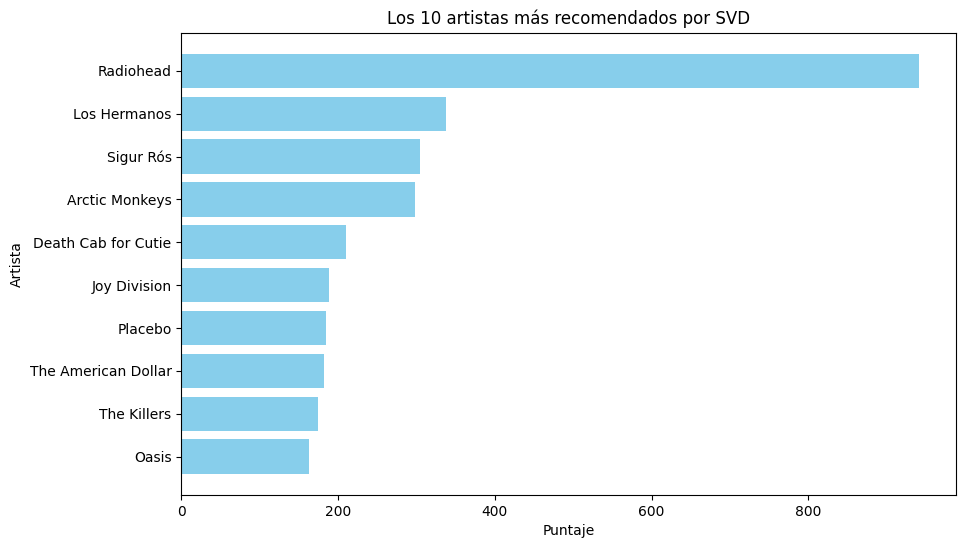

In [74]:
# Obtener la fila de recomendaciones para el usuario 8
user8_recomendations = recomendac_df.abs().iloc[8].sort_values(ascending=False)
user8_recomendations = pd.DataFrame(user8_recomendations).reset_index()
user8_recomendations.rename(columns={8: 'score'}, inplace=True)
plot_artist_ranking(user8_recomendations, df_artists, 'Los 10 artistas más recomendados por SVD')

Para este punto primero se calcula la matriz de valores singulares y se grafica la varianza explicada de esta obteniendo que con 100 valores singulares se explica casi el 95% de la varianza. Seguido a esto se toma como k=100 dado el ejercicio hecho anteriormente y se procede a reconstruir la matriz original obteniendo nuevos puntajes para cada combinación de usuario-artista. Se extrae la fila del usuario 8, se organizan los puntajes en valor absoluto de esta fila y se grafican los primeros 10 que serían las recomendaciones para hacerle al usuario.

#### 3.5.  Filtrado colaborativo usando Análisis de Canasta de Compra

Usando  el algoritmo `Apriori` genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario.  Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en los pasos anteriores. Esto puede tomar mucho tiempo, sea cuidadoso al elegir los hiper-parámetors del modelo, utilice los resultados de las estadísticas descriptivas para elegir sus hier-parámetros, y genere solo reglas con 2 elementos. (Puede también aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


In [70]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

### 4. Recomendaciones generales 

De acuerdo con los resultados encontrados, en su opinión ¿qué procedimiento generó las mejores recomendaciones para este usuario? ¿Cómo implementaría una evaluación objetiva de estas recomendaciones? Justifique su respuesta.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).